In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout, MaxPooling2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import cv2

/home/marci/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Lets take a look at the data:

healthy = os.listdir("cell-images-for-detecting-malaria/cell_images/Uninfected")
malaria = os.listdir("cell-images-for-detecting-malaria/cell_images/Parasitized")

imgs = []

labels = []
path = "cell-images-for-detecting-malaria/cell_images/Uninfected"


for data in healthy:
    name = os.path.join(path, data)
    img = cv2.imread(name)
    if img is not None:
        img = cv2.resize(img, (224,224))
        imgs.append(img)
        labels.append(1)
    if len(imgs) == 2:
        break
    
path = "cell-images-for-detecting-malaria/cell_images/Parasitized"

for data in malaria:
    name = os.path.join(path, data)
    img = cv2.imread(name)
    if img is not None:
        img = cv2.resize(img, (224,224))
        imgs.append(img)
        labels.append(0)
    if len(imgs) == 4:
        break



In [3]:
cell_mapping_dict = {0 : "Parasitized", 1 : "Uninfected"}

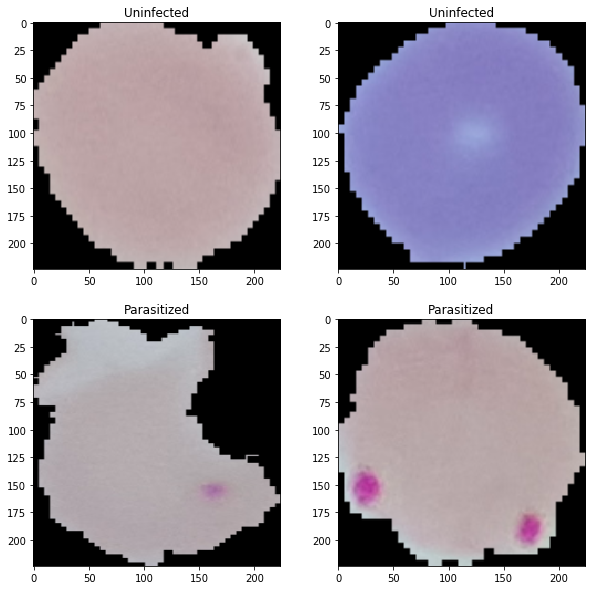

In [4]:
fig,axes = plt.subplots(2,2, squeeze=False)
fig.set_figheight(10)
fig.set_figwidth(10)
c = 0
for i in range(2):
    for j in range(2):
        axes[i,j].imshow(imgs[c])
        axes[i,j].set_title(cell_mapping_dict[labels[c]])
        c+=1
        

In [5]:
# Lets use Resnet50 pretrained on imagenet
# Batch Norm layers should stay trainable

def set_untrainable(model,up_to_what):
    for layer in model.layers:
        layer.trainable = True
    for layer in model.layers[:-up_to_what]:
        if layer.__class__.__name__ is not "BatchNormalization":
            layer.trainable = False



In [6]:
base_model = InceptionV3(weights="imagenet", input_shape = (224,224,3), include_top = False)
set_untrainable(base_model, 20)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

x = Dense(2, activation="softmax")(x)

model = Model(inputs = base_model.input, outputs = x)

In [7]:
model = load_model("weights.h5")

In [8]:
model.compile(Adam(lr = 0.0001, decay=0.000005), loss = "categorical_crossentropy", metrics=["accuracy"])

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [10]:
# Creating the datagenerator.
# Some images were moved out beforehand for testing the model
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True,rotation_range=45,
                preprocessing_function=preprocess_input, validation_split=0.2)

In [11]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [12]:
train_generator = train_datagen.flow_from_directory("cell-images-for-detecting-malaria/cell_images/",
                                                    target_size=(224,224),
                                                    batch_size=24, class_mode="categorical")

Found 27320 images belonging to 2 classes.


In [13]:
test_generator = train_datagen.flow_from_directory("cell-images-for-detecting-malaria/cell_images/",
                                                   target_size=(224,224),
                                                    batch_size=24, class_mode="categorical")

Found 27320 images belonging to 2 classes.


In [14]:
model.compile(Adam(lr = 0.000008, decay=0.000001), loss = "categorical_crossentropy", metrics=["accuracy"])

In [15]:
model.fit_generator(train_generator, steps_per_epoch= 21856 // 24, epochs = 1, validation_data=test_generator, 
                   validation_steps= 5464 // 24)

Epoch 1/1
910/910 [==============================] - 295s 324ms/step - loss: 0.1120 - acc: 0.9609 - val_loss: 0.0893 - val_acc: 0.9692


In [16]:
model.save("weights.h5")

In [27]:
# Imread the test images

healthy = os.listdir("cell-images-for-detecting-malaria/test/Uninfected")
malaria = os.listdir("cell-images-for-detecting-malaria/test/Parasitized")

imgs = []

labels = []
path = "cell-images-for-detecting-malaria/test/Uninfected"
for i in healthy:
    name = os.path.join(path, i)
    img = cv2.imread(name)
    if img is not None:
        img = cv2.resize(img, (224,224))
        imgs.append(img)
        labels.append(1)
    
path = "cell-images-for-detecting-malaria/test/Parasitized"

for i in malaria:
    name = os.path.join(path, i)
    img = cv2.imread(name)
    if img is not None:
        img = cv2.resize(img, (224,224))
        imgs.append(img)
        labels.append(0)


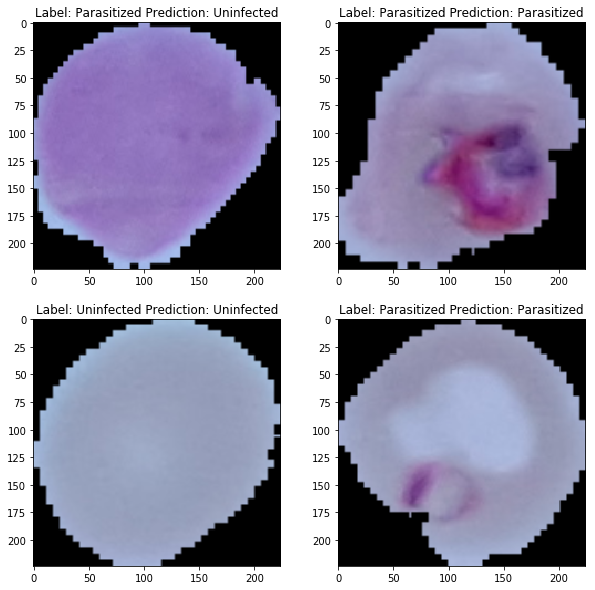

In [36]:
# Take a look at some predictions

fig,axes = plt.subplots(2,2, squeeze=False)
fig.set_figheight(10)
fig.set_figwidth(10)
c = 0
for i in range(2):
    for j in range(2):
        ind = np.random.randint(0,238)
        img = imgs[ind]
        img = cv2.resize(img, (224,224))
        img = np.array(img)
        axes[i,j].imshow(img)
        img = preprocess_input(img)
        pred = model.predict(img.reshape(1,224,224,3)).argmax()
        axes[i,j].set_title(
            "Label: %s Prediction: %s"% (cell_mapping_dict[labels[ind]], cell_mapping_dict[pred]))
            

In [42]:
# Run evaluation
y = to_categorical(labels, 2)
X_test_eval = np.array(imgs)
X_test_eval = preprocess_input(X_test_eval)

In [43]:
model.evaluate(X_test_eval, y)

238/238 [==============================] - 1s 4ms/step


[0.18088242887448863, 0.9369747904168457]

In [44]:
# Take a look at the confusion matrix and the classification report
from sklearn.metrics import classification_report, confusion_matrix
def print_metrics():
    pred = model.predict(X_test_eval)
    print(classification_report(labels[:5000],np.argmax(pred, 1)))
    print(confusion_matrix(labels[:5000], np.argmax(pred,1)))

In [45]:
print_metrics()

             precision    recall  f1-score   support

          0       1.00      0.87      0.93       119
          1       0.89      1.00      0.94       119

avg / total       0.94      0.94      0.94       238

[[104  15]
 [  0 119]]
